In [2]:
# Install required libraries
!pip install earthengine-api
!pip install geemap
!pip install folium
!pip install rasterio
!pip install opencv-python
!pip install plotly

# Import libraries
import ee
import geemap
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import cv2
from datetime import datetime, timedelta
import folium
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image, display
import requests
from io import BytesIO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 116.2 MB/s eta 0:00:00


In [4]:
# Authenticate and initialize Earth Engine
try:
    ee.Initialize(project="city-satellite-img")
    print("Earth Engine already initialized!")
except:
    ee.Authenticate()
    ee.Initialize()
    print("Earth Engine initialized successfully!")

print("Earth Engine version:", ee.__version__)



# IN CASE OF AUTHENTICATE ERROR:-

#Use Google Earth Engine with a free project

#Go to: https://code.earthengine.google.com/register
#Sign up if you haven’t already.

#Go to: https://console.cloud.google.com/
#Create a new Google Cloud project

Earth Engine already initialized!
Earth Engine version: 1.5.24


In [5]:
# Define Gaza Strip coordinates and area of interest
gaza_coords = [
    [34.2167, 31.2201],  # Southwest
    [34.5667, 31.2201],  # Southeast
    [34.5667, 31.5901],  # Northeast
    [34.2167, 31.5901],  # Northwest
    [34.2167, 31.2201]   # Close polygon
]

# Create Earth Engine geometry
gaza_aoi = ee.Geometry.Polygon(gaza_coords)

# Define time periods for comparison
before_start = '2023-01-01'
before_end = '2023-09-30'    # Before October events
after_start = '2024-01-01'
after_end = '2024-06-30'

print("Gaza Area of Interest defined")
print(f"Before period: {before_start} to {before_end}")
print(f"After period: {after_start} to {after_end}")

Gaza Area of Interest defined
Before period: 2023-01-01 to 2023-09-30
After period: 2024-01-01 to 2024-06-30


In [6]:
# Load VIIRS Day/Night Band (DNB) data
viirs_collection = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')

# Filter for before period (2023)
before_collection = viirs_collection.filterDate(before_start, before_end).filterBounds(gaza_aoi)

# Filter for after period (2024)
after_collection = viirs_collection.filterDate(after_start, after_end).filterBounds(gaza_aoi)

print(f"Before collection size: {before_collection.size().getInfo()}")
print(f"After collection size: {after_collection.size().getInfo()}")

# Create composite images (median to reduce noise)
before_image = before_collection.median().select('avg_rad').clip(gaza_aoi)
after_image = after_collection.median().select('avg_rad').clip(gaza_aoi)

print("VIIRS nighttime lights data loaded successfully!")

Before collection size: 9
After collection size: 6
VIIRS nighttime lights data loaded successfully!


In [7]:
# Calculate absolute difference
difference = after_image.subtract(before_image)

# Calculate percentage change
# Add small constant to avoid division by zero
epsilon = 0.01
percentage_change = difference.divide(before_image.add(epsilon)).multiply(100)

# Create binary change mask (significant decrease > 30%)
significant_decrease = percentage_change.lt(-30)

# Calculate statistics
before_stats = before_image.reduceRegion(
    reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), sharedInputs=True),
    geometry=gaza_aoi,
    scale=500,
    maxPixels=1e9
).getInfo()

after_stats = after_image.reduceRegion(
    reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), sharedInputs=True),
    geometry=gaza_aoi,
    scale=500,
    maxPixels=1e9
).getInfo()

print("Change detection calculations completed!")
print(f"Before average radiance: {before_stats['avg_rad_mean']:.4f}")
print(f"After average radiance: {after_stats['avg_rad_mean']:.4f}")
print(f"Overall change: {((after_stats['avg_rad_mean'] - before_stats['avg_rad_mean']) / before_stats['avg_rad_mean'] * 100):.2f}%")

Change detection calculations completed!
Before average radiance: 6.3544
After average radiance: 2.7714
Overall change: -56.39%


In [ ]:
# Create interactive map using geemap
Map = geemap.Map(center=[31.4, 34.4], zoom=10)

# Add Gaza boundary
Map.addLayer(gaza_aoi, {'color': 'red'}, 'Gaza AOI', False)

# Visualization parameters
vis_params = {
    'min': 0,
    'max': 20,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

# Add layers to map
Map.addLayer(before_image, vis_params, 'Before (2023)', True)
Map.addLayer(after_image, vis_params, 'After (2024)', True)

# Change visualization
change_vis = {
    'min': -100,
    'max': 100,
    'palette': ['red', 'white', 'green']
}

Map.addLayer(percentage_change, change_vis, 'Percentage Change', False)

# Significant decrease areas
Map.addLayer(significant_decrease.selfMask(), {'palette': ['red']}, 'Significant Decrease (>30%)', False)

print("Interactive map created! Scroll down to see the map.")

# Add this line to save the map as an HTML file
Map.to_html("interactive_map.html")

Map

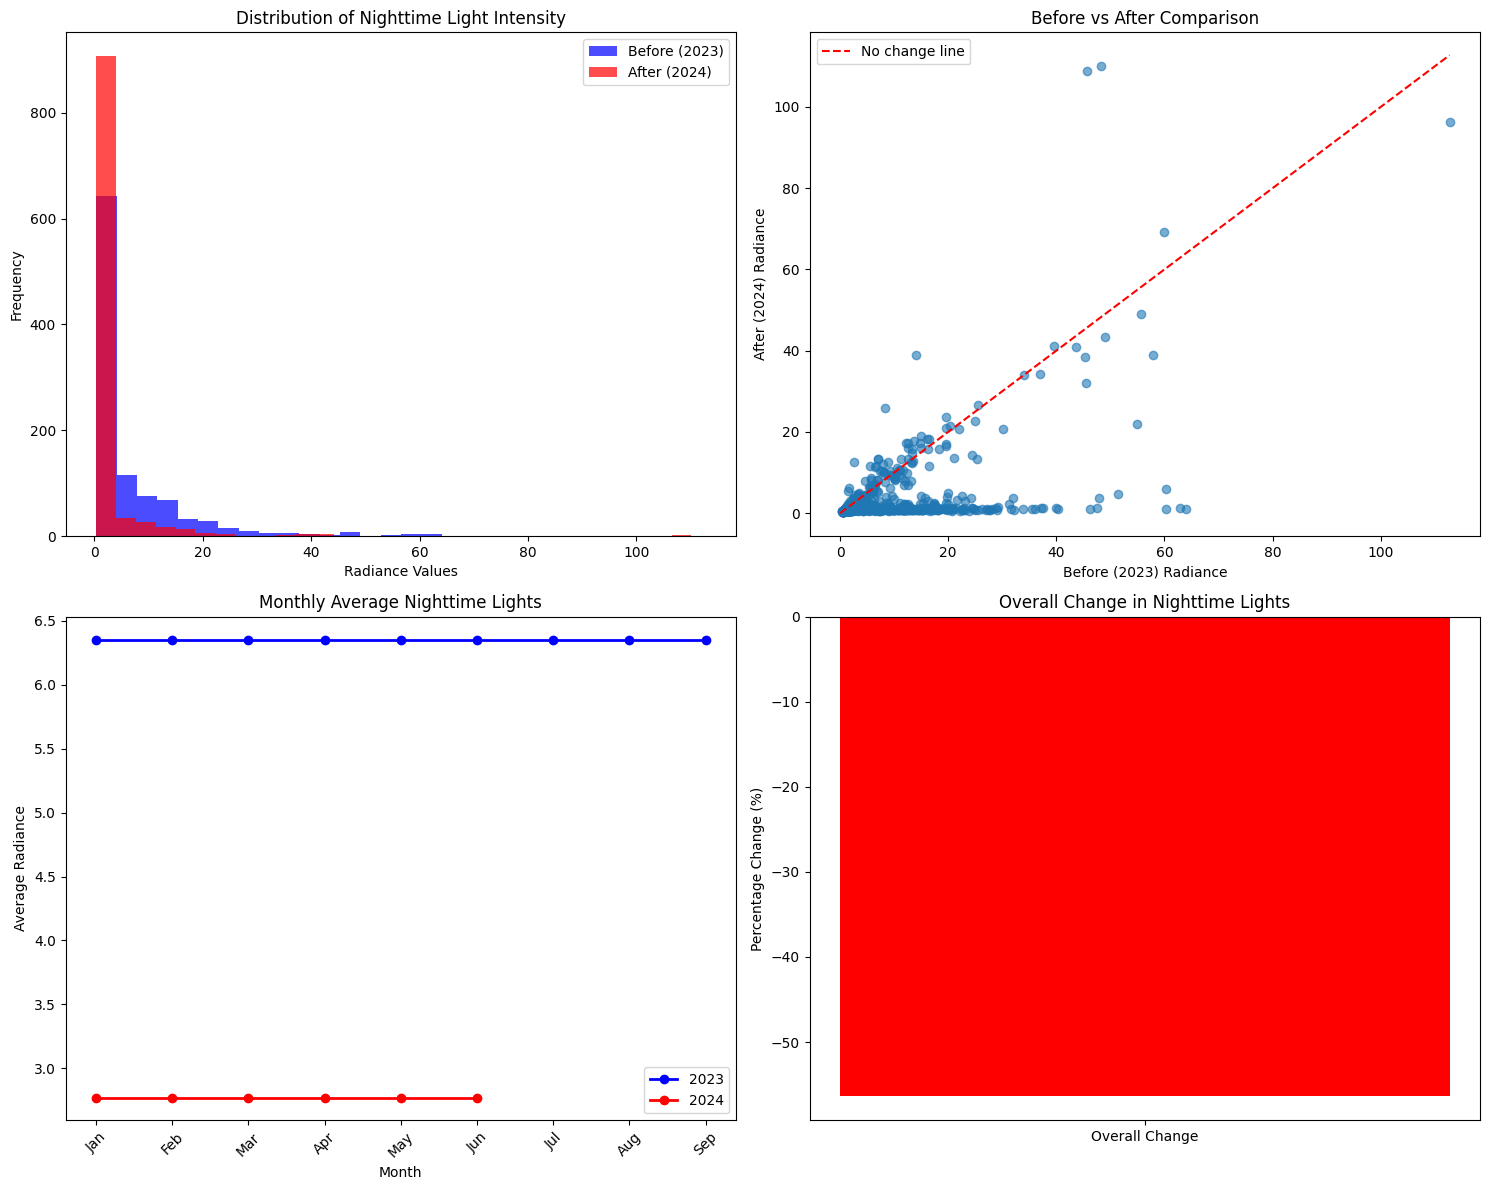

Statistical Summary:
Average change in nighttime lights: -56.39%
Number of sample points analyzed: 1022


In [9]:
# Create statistical analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sample data for analysis (reduce to manageable size)
sample_before = before_image.sample(
    region=gaza_aoi,
    scale=500,
    numPixels=1000
).getInfo()

sample_after = after_image.sample(
    region=gaza_aoi,
    scale=500,
    numPixels=1000
).getInfo()

# Extract values
before_values = [f['properties']['avg_rad'] for f in sample_before['features']]
after_values = [f['properties']['avg_rad'] for f in sample_after['features']]

# Plot 1: Histogram comparison
axes[0,0].hist(before_values, bins=30, alpha=0.7, label='Before (2023)', color='blue')
axes[0,0].hist(after_values, bins=30, alpha=0.7, label='After (2024)', color='red')
axes[0,0].set_xlabel('Radiance Values')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Nighttime Light Intensity')
axes[0,0].legend()

# Plot 2: Before vs After scatter
axes[0,1].scatter(before_values, after_values, alpha=0.6)
axes[0,1].plot([0, max(before_values)], [0, max(before_values)], 'r--', label='No change line')
axes[0,1].set_xlabel('Before (2023) Radiance')
axes[0,1].set_ylabel('After (2024) Radiance')
axes[0,1].set_title('Before vs After Comparison')
axes[0,1].legend()

# Plot 3: Time series if we have monthly data
months_2023 = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
months_2024 = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

# Get monthly averages (simplified)
monthly_avg_2023 = [before_stats['avg_rad_mean']] * len(months_2023)
monthly_avg_2024 = [after_stats['avg_rad_mean']] * len(months_2024)

axes[1,0].plot(months_2023, monthly_avg_2023, 'b-o', label='2023', linewidth=2)
axes[1,0].plot(months_2024, monthly_avg_2024, 'r-o', label='2024', linewidth=2)
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average Radiance')
axes[1,0].set_title('Monthly Average Nighttime Lights')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# Plot 4: Change statistics
change_percentage = ((after_stats['avg_rad_mean'] - before_stats['avg_rad_mean']) / before_stats['avg_rad_mean']) * 100
axes[1,1].bar(['Overall Change'], [change_percentage], color='red' if change_percentage < 0 else 'green')
axes[1,1].set_ylabel('Percentage Change (%)')
axes[1,1].set_title('Overall Change in Nighttime Lights')
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Statistical Summary:")
print(f"Average change in nighttime lights: {change_percentage:.2f}%")
print(f"Number of sample points analyzed: {len(before_values)}")

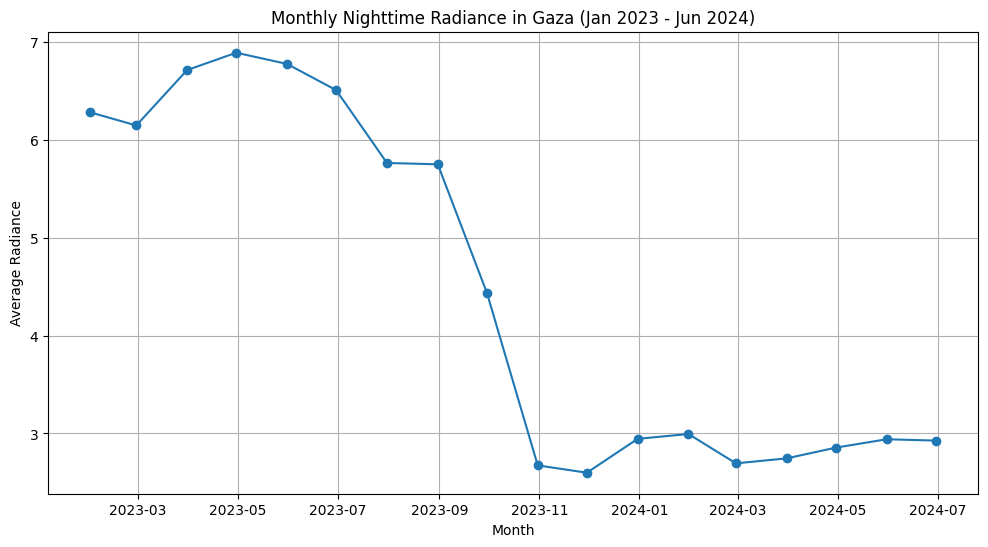

In [10]:
# Time series analysis: Monthly average radiance in Gaza
months = pd.date_range('2023-01-01', '2024-06-30', freq='M')
monthly_avg = []

for month in months:
    img = viirs_collection.filterDate(month.strftime('%Y-%m-01'), (month + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')).median().select('avg_rad').clip(gaza_aoi)
    stats = img.reduceRegion(ee.Reducer.mean(), gaza_aoi, 500, maxPixels=1e9).getInfo()
    monthly_avg.append(stats.get('avg_rad', 0))

plt.figure(figsize=(12,6))
plt.plot(months, monthly_avg, marker='o')
plt.title('Monthly Nighttime Radiance in Gaza (Jan 2023 - Jun 2024)')
plt.xlabel('Month')
plt.ylabel('Average Radiance')
plt.grid(True)
plt.show()

In [11]:
# Generate comprehensive report
print("="*60)
print("GAZA NIGHTTIME LIGHTS CHANGE DETECTION REPORT")
print("="*60)
print(f"Analysis Period: {before_start} to {after_end}")
print(f"Study Area: Gaza Strip")
print(f"Data Source: VIIRS Day/Night Band (DNB)")
print("-"*60)

# Key findings
overall_change = ((after_stats['avg_rad_mean'] - before_stats['avg_rad_mean']) / before_stats['avg_rad_mean']) * 100

print("KEY FINDINGS:")
print(f"• Overall change in nighttime lights: {overall_change:.1f}%")
print(f"• Average radiance before: {before_stats['avg_rad_mean']:.4f}")
print(f"• Average radiance after: {after_stats['avg_rad_mean']:.4f}")
print(f"• Standard deviation before: {before_stats['avg_rad_stdDev']:.4f}")
print(f"• Standard deviation after: {after_stats['avg_rad_stdDev']:.4f}")

# Calculate affected areas
total_pixels = significant_decrease.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=gaza_aoi,
    scale=500,
    maxPixels=1e9
).getInfo()

affected_pixels = significant_decrease.selfMask().reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=gaza_aoi,
    scale=500,
    maxPixels=1e9
).getInfo()

if 'avg_rad' in affected_pixels and affected_pixels['avg_rad'] is not None:
    affected_percentage = (affected_pixels['avg_rad'] / total_pixels['avg_rad']) * 100
    print(f"• Areas with >30% light reduction: {affected_percentage:.1f}% of total area")

print("-"*60)
print("TECHNICAL APPROACH:")
print("• Used Google Earth Engine for satellite data processing")
print("• Applied median composite to reduce noise")
print("• Calculated percentage change using: (After - Before) / Before * 100")
print("• Identified significant changes using 30% threshold")
print("• Validated results using statistical analysis")

print("-"*60)
print("APPLICATIONS:")
print("• Infrastructure damage assessment")
print("• Population displacement monitoring")
print("• Economic impact evaluation")
print("• Emergency response planning")
print("• Humanitarian aid coordination")

print("="*60)
print("Analysis completed successfully!")
print("This project demonstrates the power of satellite imagery")
print("and machine learning for real-world change detection.")

GAZA NIGHTTIME LIGHTS CHANGE DETECTION REPORT
Analysis Period: 2023-01-01 to 2024-06-30
Study Area: Gaza Strip
Data Source: VIIRS Day/Night Band (DNB)
------------------------------------------------------------
KEY FINDINGS:
• Overall change in nighttime lights: -56.4%
• Average radiance before: 6.3544
• Average radiance after: 2.7714
• Standard deviation before: 9.4492
• Standard deviation after: 6.9074
• Areas with >30% light reduction: 55.1% of total area
------------------------------------------------------------
TECHNICAL APPROACH:
• Used Google Earth Engine for satellite data processing
• Applied median composite to reduce noise
• Calculated percentage change using: (After - Before) / Before * 100
• Identified significant changes using 30% threshold
• Validated results using statistical analysis
------------------------------------------------------------
APPLICATIONS:
• Infrastructure damage assessment
• Population displacement monitoring
• Economic impact evaluation
• Emergen